# Validation RMSE

An experiment on difference between "Exponentiated Log-RMSE" and "original scale"

Validating testset RMSE (kWh) results shown on Table 2 

Paper: https://link.springer.com/article/10.1007/s12053-024-10264-3



## Synthetic Dataset For UK Household Gas Consumption

- generate a random dataset with 1000 rows and 6 columns to represent the mean daily gas consumption of 1000 households in the UK
- the target is the mean daily gas consumption of each household, the 5 features are named as 'feature_1', 'feature_2', ..., 'feature_5'
- the mean daily gas consumption (unit kWh) of each household need to reflect the actually gas consumption of households in the UK (average value is 35kWh)
- the distubution of the mean daily gas consumption of each household is not normal, and slightly skewed to the left. similart to the paper.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# generate synthetic data
np.random.seed(42)
num_households = 1000
mean_gas_consumption = np.random.gamma(shape=5, scale=7, size=num_households)  # Gamma distribution produces a skewed distribution

# Generate 5 random features for the households
features = {
    f'feature_{i}': np.random.uniform(0, 1, size=num_households) for i in range(1, 6)
}
data = pd.DataFrame(features)
data['mean_daily_gas_consumption_kWh'] = mean_gas_consumption
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,mean_daily_gas_consumption_kWh
0,0.607090,0.792758,0.659690,0.971845,0.842538,40.768243
1,0.631308,0.069046,0.442033,0.512615,0.500877,30.620161
2,0.591697,0.474255,0.648233,0.290877,0.981421,29.252254
3,0.702634,0.560678,0.061446,0.469407,0.097377,29.252484
4,0.237433,0.628426,0.813723,0.857858,0.303066,62.838889


<Axes: ylabel='Frequency'>

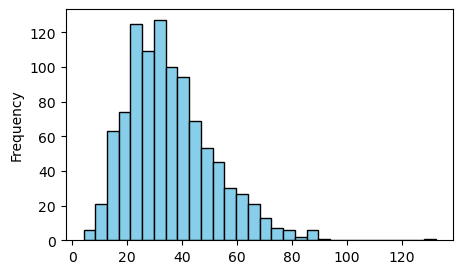

In [3]:
# distribution of the target variable by plt
data['mean_daily_gas_consumption_kWh'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue', figsize=(5, 3))

<Axes: ylabel='Frequency'>

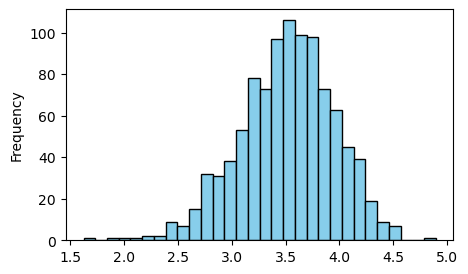

In [4]:
# create a column for log-transformed gas consumption (natural logarithm (base e). and check the distribution
data['log_mean_daily_gas_consumption_kWh'] = np.log1p(data['mean_daily_gas_consumption_kWh'])
# distribution of the target variable by plt
data['log_mean_daily_gas_consumption_kWh'].plot(kind='hist', bins=30, edgecolor='black', color='skyblue', figsize=(5, 3))

## LASSO Model training

In [5]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split

X = data.drop(['mean_daily_gas_consumption_kWh', 'log_mean_daily_gas_consumption_kWh'], axis=1)
y = data['log_mean_daily_gas_consumption_kWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a Lasso regression model with optimal alpha
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Train a Lasso regression model
model = Lasso(alpha=0.001, random_state=42)
model.fit(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train RMSE: 0.4420
Test RMSE: 0.4115


### Calculate RMSE "error" relative to the mean consumption

- it is used to compare models or datasets with different average consumption levels.

- If two datasets have different average gas consumption levels, this metric helps normalize the error, enabling a fair comparison.

In [6]:
# calculate test RMSE by using Exponentiated Log-RMSE , e^(log-RMSE), same to method used in paper by inference
test_rmse_method_1 = np.exp(test_rmse) 
print(f'Test RMSE by method 1: {test_rmse_method_1:.4f}')

# calculate error by using Exponentiated Log-RMSE , e^(log-RMSE) (35 kWh is the average gas consumption)

average_gas_consumption = 35
error = (test_rmse_method_1 / average_gas_consumption)
print(f'Error (method 1): {error:.2f} %')

Test RMSE by method 1: 1.5091
Error (method 1): 0.04 %


In [7]:
# calculate test RMSE by Back-transforming the predictions (not RMSE itself) to the original scale.and then calculate RMSE, and the error
test_preds_original_scale = np.expm1(test_preds)
test_rmse_method_2 = mean_squared_error(np.expm1(y_test), test_preds_original_scale, squared=False)
print(f'Test RMSE by method2 : {test_rmse_method_2:.4f}')

error = (test_rmse_method_2 / average_gas_consumption)
print(f'Error (method 2): {error:.2f} %')

Test RMSE by method2 : 13.3751
Error (method 2): 0.38 %


## More step by predicting original value and see RMSE

In [8]:
# split the data into training and test sets
from sklearn.model_selection import train_test_split

X = data.drop(['mean_daily_gas_consumption_kWh', 'log_mean_daily_gas_consumption_kWh'], axis=1)
y = data['mean_daily_gas_consumption_kWh'] # use the original target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train a Lasso regression model with optimal alpha
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Train a Lasso regression model
model = Lasso(alpha=0.001, random_state=42)
model.fit(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, train_preds, squared=False)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

error = (test_rmse / average_gas_consumption)
print(f'Error : {error:.2f} %')

Train RMSE: 16.1149
Test RMSE: 13.2847
Error : 0.38 %


## Conclusion

So the actual RMSE error to mean gas consumption at original scale (kWh) should be 0.38%, rather than 0.04%. 

so the method 1 underestimates the RMSE and relative errors by a factor of approximately 9 times. (0.38/0.04)